[Orignal paper](https://arxiv.org/abs/1502.03167)

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm
from MyHelper import *
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
downloadData(filename,loc)

In [4]:
X,y=getData(filename,loc,flat=True)

In [5]:
print(X.shape,y.shape)

(60000, 784) (60000, 10)


In [6]:
img_size = np.sqrt(X.shape[1])
print(img_size)

28.0


/Users/tmulc/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


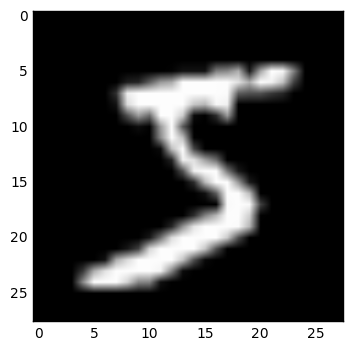

In [7]:
plt.imshow(X[0,:].reshape(img_size,img_size),cmap='gray')

# Model

In [8]:
def createWeight(size):
    return tf.Variable(tf.truncated_normal(size, stddev=0.1))

def createBias(size):
    return tf.Variable(tf.constant(0.1,shape=size))

def lrelu(x, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x)

In [9]:
batch_size = 32
num_nodes=1000
g = tf.Graph()
with g.as_default():
    img_input = tf.placeholder(tf.float32,shape=(batch_size,int(img_size**2)))
    targets = tf.placeholder(tf.float32,shape=(batch_size,10))
    
    
    #create weights
    W1 = createWeight([int(img_size**2),num_nodes])
    b1 = createBias([num_nodes])
    
    W2 = createWeight([num_nodes,num_nodes])
    b2 = createBias([num_nodes])
    
    W_logit = createWeight([num_nodes,10])
    b_logit = createBias([10])

    
    #model
    h1 = tf.nn.relu(tf.matmul(img_input,W1)+b1)
    h2 = tf.nn.relu(tf.matmul(h1,W2)+b2)
    logit = tf.matmul(h2,W_logit)+b_logit
    
    #train
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logit,targets))
    opt = tf.train.AdamOptimizer(learning_rate=.005).minimize(loss)
    
    train_accuracy = tf.reduce_mean(tf.cast(tf.equal(
        tf.arg_max(tf.nn.softmax(logit),1),tf.arg_max(targets,1)),tf.float32))
    
    init = tf.initialize_all_variables()

In [10]:
sess=tf.Session(graph=g)
sess.run(init)
losses = []

In [11]:
num_steps = 1000
for s in tqdm(range(num_steps)):
    fd = {img_input:X[(s*batch_size)%X.shape[0]:(s*batch_size+batch_size) % X.shape[0],:],
         targets:y[(s*batch_size)%y.shape[0]:(s*batch_size+batch_size)%y.shape[0],:]}
    l,_ = sess.run([loss,opt],feed_dict=fd)
    losses.append(l)
    if s % 100 == 0:
        print(sess.run([train_accuracy],feed_dict=fd))

  2%|▏         | 24/1000 [00:00<00:08, 113.10it/s]

[0.40625]


 11%|█▏        | 114/1000 [00:00<00:07, 124.64it/s]

[0.84375]


 22%|██▏       | 219/1000 [00:01<00:06, 126.25it/s]

[0.96875]


 32%|███▎      | 325/1000 [00:02<00:05, 123.11it/s]

[0.90625]


 42%|████▏     | 417/1000 [00:03<00:04, 126.73it/s]

[0.96875]


 52%|█████▏    | 523/1000 [00:04<00:03, 126.49it/s]

[0.84375]


 62%|██████▏   | 615/1000 [00:04<00:03, 126.31it/s]

[0.875]


 72%|███████▏  | 720/1000 [00:05<00:02, 124.60it/s]

[0.875]


 82%|████████▎ | 825/1000 [00:06<00:01, 122.26it/s]

[0.875]


 91%|█████████▏| 914/1000 [00:07<00:00, 118.20it/s]

[0.96875]


100%|██████████| 1000/1000 [00:08<00:00, 123.74it/s]


In [12]:
p = figure(title="training loss", x_axis_label='train steps', y_axis_label='loss')
p.line(range(len(losses)),losses)
show(p)

# Batch Normalization

In [13]:
batch_size = 32
num_nodes=1000
eps = .0001
g = tf.Graph()
with g.as_default():
    img_input = tf.placeholder(tf.float32,shape=(batch_size,int(img_size**2)))
    targets = tf.placeholder(tf.float32,shape=(batch_size,10))
    
    
    #create weights
    gamma0 = tf.Variable(tf.truncated_normal([int(img_size**2)]))
    beta0 = tf.Variable(tf.ones([int(img_size**2)]))
    
    W1 = createWeight([int(img_size**2),num_nodes])
    b1 = createBias([num_nodes])
    
    gamma1 = tf.Variable(tf.truncated_normal([num_nodes]))
    beta1 = tf.Variable(tf.ones([num_nodes]))
    
    W2 = createWeight([num_nodes,num_nodes])
    b2 = createBias([num_nodes])
    
    gamma2 = tf.Variable(tf.truncated_normal([num_nodes]))
    beta2 = tf.Variable(tf.ones([num_nodes]))
    
    W_logit = createWeight([num_nodes,10])
    b_logit = createBias([10])
    
    gammalo = tf.Variable(tf.truncated_normal([10]))
    betalo = tf.Variable(tf.ones([10]))

    
    #model
    mu0 = tf.reduce_mean(img_input,[0],keep_dims=True)
    sigma0 = tf.reduce_mean(tf.square(img_input-mu0),[0],keep_dims=True)
    input_hat = (img_input-mu0)/(tf.sqrt(sigma0+eps))
    input_out = gamma0*input_hat+beta0
    
    h1 = tf.nn.relu(tf.matmul(input_out,W1)+b1)
    mu1 = tf.reduce_mean(h1,[0],keep_dims=True)
    sigma1 = tf.reduce_mean(tf.square(h1-mu1),[0],keep_dims=True)
    h1_hat = (h1-mu1)/(tf.sqrt(sigma1+eps))
    h1_out = gamma1*h1_hat+beta1
    
    h2 = tf.nn.relu(tf.matmul(h1_out,W2)+b2)
    mu2 = tf.reduce_mean(h2,[0],keep_dims=True)
    sigma2 = tf.reduce_mean(tf.square(h2-mu2),[0],keep_dims=True)
    h2_hat = (h2-mu2)/(tf.sqrt(sigma2+eps))
    h2_out = gamma2*h2_hat+beta2

    logit = tf.matmul(h2_out,W_logit)+b_logit
    mulo = tf.reduce_mean(logit,[0],keep_dims=True)
    sigmalo = tf.reduce_mean(tf.square(logit-mulo),[0],keep_dims=True)
    lo_hat = (logit-mulo)/(tf.sqrt(sigmalo+eps))
    lo_out = gammalo*lo_hat+betalo
    
    #train
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(lo_out,targets))
    
    opt = tf.train.AdamOptimizer(learning_rate=.005).minimize(loss)
    
    train_accuracy = tf.reduce_mean(tf.cast(tf.equal(
        tf.arg_max(tf.nn.softmax(lo_out),1),tf.arg_max(targets,1)),tf.float32))
    
    init = tf.initialize_all_variables()

In [14]:
sess=tf.Session(graph=g)
sess.run(init)
losses = []

In [15]:
num_steps = 1000
for s in tqdm(range(num_steps)):
    fd = {img_input:X[(s*batch_size)%X.shape[0]:(s*batch_size+batch_size) % X.shape[0],:],
         targets:y[(s*batch_size)%y.shape[0]:(s*batch_size+batch_size)%y.shape[0],:]}
    l,_ = sess.run([loss,opt],feed_dict=fd)
    losses.append(l)
    if s % 100 == 0:
        print(sess.run([train_accuracy],feed_dict=fd))

  1%|▏         | 14/1000 [00:00<00:18, 52.49it/s]

[0.625]


 11%|█         | 112/1000 [00:01<00:10, 82.78it/s]

[0.875]


 21%|██        | 211/1000 [00:02<00:09, 81.62it/s]

[0.84375]


 31%|███       | 310/1000 [00:03<00:08, 83.54it/s]

[0.84375]


 42%|████▏     | 418/1000 [00:05<00:06, 84.34it/s]

[0.78125]


 52%|█████▏    | 517/1000 [00:06<00:05, 82.09it/s]

[0.8125]


 62%|██████▏   | 615/1000 [00:07<00:05, 75.32it/s]

[0.84375]


 71%|███████▏  | 714/1000 [00:08<00:03, 76.34it/s]

[0.90625]


 81%|████████▏ | 814/1000 [00:10<00:02, 66.89it/s]

[0.9375]


 91%|█████████ | 911/1000 [00:11<00:01, 81.58it/s]

[0.875]


100%|██████████| 1000/1000 [00:12<00:00, 79.45it/s]


In [16]:
p = figure(title="training loss", x_axis_label='train steps', y_axis_label='loss')
p.line(range(len(losses)),losses)
show(p)

# Simplify code

In [17]:
def createWeightsBN(s):
    """
    Creates weights for batch normalization layer
    
    Parameters:
    -----------
    s: int
        size of to be normalized
    """
    gamma = tf.Variable(tf.truncated_normal([s]))
    beta = tf.Variable(tf.ones([s]))
    return [gamma,beta]

def BN(x,variables,eps=.0001):
    """
    Applies Batch Normalization
    
    Parameters:
    ------------
    x: tensor
        the data to normalize
    variables: [gamma,beta]
        parameters to learn
        
    eps (optional): float
        small number to keep from dividing by zero
    """
    gamma,beta = variables[0],variables[1]
    
    mu = tf.reduce_mean(x,[0],keep_dims=True)
    sigma = tf.reduce_mean(tf.square(x-mu),[0],keep_dims=True)
    x_hat = (x-mu)/(tf.sqrt(sigma+eps))
    y = gamma*x_hat+beta
    return y

In [19]:
batch_size = 32
num_nodes=1000
eps = .0001
g = tf.Graph()
with g.as_default():
    img_input = tf.placeholder(tf.float32,shape=(batch_size,int(img_size**2)))
    targets = tf.placeholder(tf.float32,shape=(batch_size,10))
    
    
    #create weights
    bn_0 = createWeightsBN(int(img_size**2))
    
    W1 = createWeight([int(img_size**2),num_nodes])
    b1 = createBias([num_nodes])
    
    bn_1 = createWeightsBN(num_nodes)
    
    W2 = createWeight([num_nodes,num_nodes])
    b2 = createBias([num_nodes])
    
    bn_2 = createWeightsBN(num_nodes)
    
    W_logit = createWeight([num_nodes,10])
    b_logit = createBias([10])
    
    bn_logit = createWeightsBN(10)

    
    #model
    input_bn = BN(img_input,bn_0)
    
    h1 = tf.nn.relu(tf.matmul(input_bn,W1)+b1)
    h1_bn = BN(h1,bn_1)
    
    h2 = tf.nn.relu(tf.matmul(h1_bn,W2)+b2)
    h2_bn = BN(h2,bn_2)

    logit = tf.matmul(h2_bn,W_logit)+b_logit
    lo_bn = BN(logit,bn_logit)
    
    #train
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(lo_bn,targets))
    opt = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)
    
    train_accuracy = tf.reduce_mean(tf.cast(tf.equal(
        tf.arg_max(tf.nn.softmax(lo_bn),1),tf.arg_max(targets,1)),tf.float32))
    
    init = tf.initialize_all_variables()

In [20]:
sess=tf.Session(graph=g)
sess.run(init)
losses = []

In [21]:
num_steps = 1000
for s in tqdm(range(num_steps)):
    fd = {img_input:X[(s*batch_size)%X.shape[0]:(s*batch_size+batch_size) % X.shape[0],:],
         targets:y[(s*batch_size)%y.shape[0]:(s*batch_size+batch_size)%y.shape[0],:]}
    l,_ = sess.run([loss,opt],feed_dict=fd)
    losses.append(l)
    if s % 100 == 0:
        print(sess.run([train_accuracy],feed_dict=fd))

  1%|▏         | 14/1000 [00:00<00:17, 54.88it/s]

[0.71875]


 11%|█         | 111/1000 [00:01<00:10, 82.83it/s]

[0.84375]


 21%|██        | 210/1000 [00:02<00:09, 83.54it/s]

[0.84375]


 31%|███▏      | 313/1000 [00:03<00:09, 75.17it/s]

[0.84375]


 41%|████      | 410/1000 [00:05<00:06, 84.79it/s]

[0.78125]


 52%|█████▏    | 518/1000 [00:06<00:05, 82.47it/s]

[0.84375]


 62%|██████▏   | 616/1000 [00:07<00:04, 82.63it/s]

[0.90625]


 72%|███████▏  | 715/1000 [00:08<00:03, 85.00it/s]

[0.90625]


 81%|████████▏ | 814/1000 [00:09<00:02, 85.38it/s]

[0.96875]


 91%|█████████▏| 913/1000 [00:11<00:01, 83.61it/s]

[0.90625]


100%|██████████| 1000/1000 [00:12<00:00, 81.70it/s]


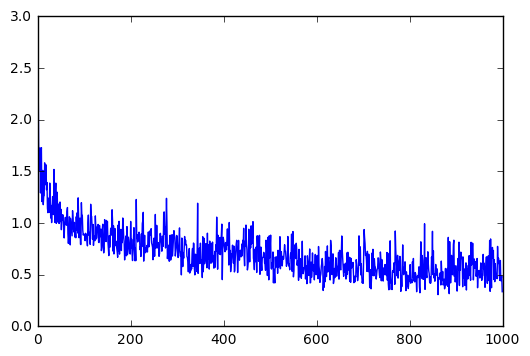

In [22]:
plt.plot(losses)